In [56]:
import torch 
import torch.nn as nn 
import numpy as np 
import matplotlib.pyplot as  plt 
from PIL import Image 
import cv2 
import uuid 
import os, time, json, pickle 
from torchvision import transforms
from torchvision.models import vgg19
from torchinfo import summary 

In [9]:
class Transform():
    def __init__(self, resize, mean, std):
        self.data_transform = transforms.Compose([
                                        transforms.Resize((resize, resize)),
                                        transforms.ToTensor(), 
                                        transforms.Normalize(mean, std)
        ])  
    def __call__(self, img):
        return self.data_transform(img)

RESIZE = 368
MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)
transform = Transform(RESIZE, MEAN, STD)

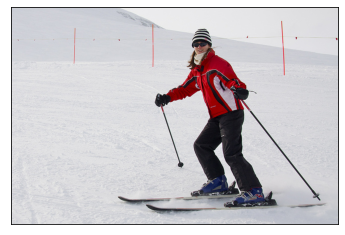

torch.Size([1, 3, 368, 368])


In [10]:
sample = "1.jpg"
sample = Image.open(sample)
# sample = transform(sample)
plt.imshow(sample)
plt.xticks([])
plt.yticks([])
plt.show()

img_tensor = transform(sample).unsqueeze(0)
print(img_tensor.size())

In [13]:
class conv2Relu(nn.Module):
    def __init__(self, in_c, out_c, kernel_size, stride, padding):
        super(conv2Relu, self).__init__()
        self.conv = nn.Conv2d(in_c, out_c, kernel_size, stride, padding=padding)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.relu(self.conv(x))

class Feature(nn.Module):
    def __init__(self):
        super(Feature, self).__init__()
        '''通常の畳み込み層'''
        self.vgg = vgg19(pretrained=True).features[0:23] # -> (b, 512, 46, 46)
        self.layer1 = conv2Relu(512, 256, 3, 1, 1)
        self.layer2 = conv2Relu(256, 128, 3, 1, 1)

    def forward(self, x):
        '''
        (b, 3, 368, 368) -> (b, 128, 46, 46)
        '''
        y = self.vgg(x)
        y = self.layer1(y)
        y = self.layer2(y)
        return y 

In [38]:
class Stage1(nn.Module):
    def __init__(self, in_c, mid_c, out_c):
        super(Stage1, self).__init__()
        self.layer1 = conv2Relu(in_c, in_c, 3, 1, 1)
        self.layer2 = conv2Relu(in_c, in_c, 3, 1, 1)
        self.layer3 = conv2Relu(in_c, in_c, 3, 1, 1)
        self.layer4 = conv2Relu(in_c, mid_c, 1, 1, 0)
        self.layer5 = nn.Conv2d(mid_c, out_c, 1, 1, padding=0)

    def forward(self, x):
        y = self.layer1(x)
        y = self.layer2(y)
        y = self.layer3(y)
        y = self.layer4(y)
        y = self.layer5(y)
        return y 

class Stage2(nn.Module):
    def __init__(self, in_c, mid_c, out_c):
        super(Stage2, self).__init__()
        self.layer1 = conv2Relu(in_c, mid_c, 7, 1, 3)
        self.layer2 = conv2Relu(mid_c, mid_c, 7, 1, 3)
        self.layer3 = conv2Relu(mid_c, mid_c, 7, 1, 3)
        self.layer4 = conv2Relu(mid_c, mid_c, 7, 1, 3)
        self.layer5 = conv2Relu(mid_c, mid_c, 7, 1, 3)
        self.layer6 = conv2Relu(mid_c, mid_c, 1, 1, 0)
        self.layer7 = nn.Conv2d(mid_c, out_c, 1, 1, padding=0)

    def forward(self, x):
        y = self.layer1(x)
        y = self.layer2(y)
        y = self.layer3(y)
        y = self.layer4(y)
        y = self.layer5(y)
        y = self.layer6(y)
        y = self.layer7(y)
        return y 

class OpenPoseNet(nn.Module):
    def __init__(self):
        super(OpenPoseNet, self).__init__()
        concat_size = 128+38+19
        self.feature = Feature()
        # pafs層 (b, 38, 46, 46)
        self.module1_1 = Stage1(128, 512, 38)
        self.module1_2 = Stage2(concat_size, 128, 38)
        self.module1_3 = Stage2(concat_size, 128, 38)
        self.module1_4 = Stage2(concat_size, 128, 38)
        self.module1_5 = Stage2(concat_size, 128, 38)
        self.module1_6 = Stage2(concat_size, 128, 38)
        # heatmap層 (b, 19, 6, 46)
        self.module2_1 = Stage1(128, 512, 19)
        self.module2_2 = Stage2(concat_size, 128, 19)
        self.module2_3 = Stage2(concat_size, 128, 19)
        self.module2_4 = Stage2(concat_size, 128, 19)
        self.module2_5 = Stage2(concat_size, 128, 19)
        self.module2_6 = Stage2(concat_size, 128, 19)

        self.outputs = []

    def forward(self, x):
        out = self.feature(x)

        out1_1 = self.module1_1(out)
        out1_2 = self.module2_1(out)
        out1 = torch.cat((out, out1_1, out1_2), dim=1)

        out2_1 = self.module1_2(out1)
        out2_2 = self.module2_2(out1)
        out2 = torch.cat((out, out2_1, out2_2), dim=1)

        out3_1 = self.module1_3(out2)
        out3_2 = self.module2_3(out2)
        out3 = torch.cat((out, out3_1, out3_2), dim=1)

        out4_1 = self.module1_4(out3)
        out4_2 = self.module2_4(out3)
        out4 = torch.cat((out, out4_1, out4_2), dim=1)

        out5_1 = self.module1_5(out4)
        out5_2 = self.module2_5(out4)
        out5 = torch.cat((out, out5_1, out5_2), dim=1)

        out6_1 = self.module1_6(out5)
        out6_2 = self.module2_6(out5)

        self.outputs.append(out1_1)
        self.outputs.append(out1_2)
        self.outputs.append(out2_1)
        self.outputs.append(out2_2)
        self.outputs.append(out3_1)
        self.outputs.append(out3_2)
        self.outputs.append(out4_1)
        self.outputs.append(out4_2)
        self.outputs.append(out5_1)
        self.outputs.append(out5_2)
        self.outputs.append(out6_1)
        self.outputs.append(out6_2)

        return self.outputs 


In [44]:
net = OpenPoseNet()
summary(net, input_size=(2, 3, 368, 386))

Layer (type:depth-idx)                   Output Shape              Param #
OpenPoseNet                              --                        --
├─Feature: 1-1                           [2, 128, 46, 48]          --
│    └─Sequential: 2-1                   [2, 512, 46, 48]          --
│    │    └─Conv2d: 3-1                  [2, 64, 368, 386]         1,792
│    │    └─ReLU: 3-2                    [2, 64, 368, 386]         --
│    │    └─Conv2d: 3-3                  [2, 64, 368, 386]         36,928
│    │    └─ReLU: 3-4                    [2, 64, 368, 386]         --
│    │    └─MaxPool2d: 3-5               [2, 64, 184, 193]         --
│    │    └─Conv2d: 3-6                  [2, 128, 184, 193]        73,856
│    │    └─ReLU: 3-7                    [2, 128, 184, 193]        --
│    │    └─Conv2d: 3-8                  [2, 128, 184, 193]        147,584
│    │    └─ReLU: 3-9                    [2, 128, 184, 193]        --
│    │    └─MaxPool2d: 3-10              [2, 128, 92, 96]          --

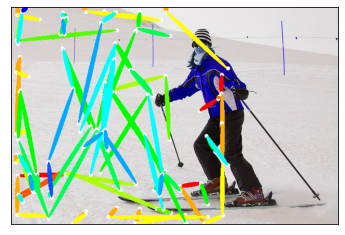

saving result image for path results/dbe3.png 


In [58]:
def load_weight(net, filename="pose_model_scratch.pth"):
    weights = torch.load(filename, map_location={"cuda:0": "cpu"})
    keys = list(weights.keys())
    load_w = {}

    for i in range(len(keys)):
        load_w[list(net.state_dict().keys())[i]] = weights[list(keys)[i]]

    state = net.state_dict()
    state.update(load_w)
    net.load_state_dict(state)
    net.eval()
    return net 


def show_img(img):
    fig = plt.figure()
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    os.makedirs("results", exist_ok=True)
    id = uuid.uuid4()
    fig.savefig(f"results/{str(id)[:4]}.png")
    print(f"saving result image for path results/{str(id)[:4]}.png ")

def detect(net, img_tensor):
    with torch.no_grad():
        output = net(img_tensor)
        heatmap = output[-1][0].detach().cpu().numpy().transpose(1, 2, 0)
        pafs = output[-2][0].detach().cpu().numpy().transpose(1, 2, 0)
    return heatmap, pafs 

def inference(img_path: str):
    # モデルの読み込み
    net = OpenPoseNet()
    net = load_weight(net)
    # 画像の前処理
    img = Image.open(img_path)
    oriImg = cv2.cvtColor(np.uint8(img), cv2.COLOR_BGR2RGB)
    img_tensor = transform(img).unsqueeze(0)
    # 推論
    heatmap, pafs = detect(net, img_tensor)
    _, result_img, _, _ = decode_pose(oriImg, heatmap, pafs)
    # 画像の表示
    show_img(result_img)

inference("1.jpg")

In [47]:
# 以下を一部変更し、ほぼそのまま使用
# https://github.com/tensorboy/pytorch_Realtime_Multi-Person_Pose_Estimation/blob/master/network/post.py
# Released under the MIT license
import math
import cv2
import matplotlib.cm
import numpy as np
from scipy.ndimage.filters import gaussian_filter, maximum_filter
from scipy.ndimage.morphology import generate_binary_structure

# It is better to use 0.1 as threshold when evaluation, but 0.3 for demo
# purpose.
cmap = matplotlib.cm.get_cmap('hsv')

# Heatmap indices to find each limb (joint connection). Eg: limb_type=1 is
# Neck->LShoulder, so joint_to_limb_heatmap_relationship[1] represents the
# indices of heatmaps to look for joints: neck=1, LShoulder=5
joint_to_limb_heatmap_relationship = [
    [1, 2], [1, 5], [2, 3], [3, 4], [5, 6], [6, 7], [1, 8], [8, 9], [9, 10],
    [1, 11], [11, 12], [12, 13], [1, 0], [0, 14], [14, 16], [0, 15], [15, 17],
    [2, 16], [5, 17]]

# PAF indices containing the x and y coordinates of the PAF for a given limb.
# Eg: limb_type=1 is Neck->LShoulder, so
# PAFneckLShoulder_x=paf_xy_coords_per_limb[1][0] and
# PAFneckLShoulder_y=paf_xy_coords_per_limb[1][1]
paf_xy_coords_per_limb = [
    [12, 13], [20, 21], [14, 15], [16, 17], [22, 23],
    [24, 25], [0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11], [28, 29],
    [30, 31], [34, 35], [32, 33], [36, 37], [18, 19], [26, 27]]

# Color code used to plot different joints and limbs (eg: joint_type=3 and
# limb_type=3 will use colors[3])
colors = [
    [255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0],
    [85, 255, 0], [0, 255, 0], [0, 255, 85], [0, 255, 170], [0, 255, 255],
    [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], [170, 0, 255],
    [255, 0, 255], [255, 0, 170], [255, 0, 85], [255, 0, 0]]

NUM_JOINTS = 18
NUM_LIMBS = len(joint_to_limb_heatmap_relationship)


def find_peaks(param, img):
    """
    Given a (grayscale) image, find local maxima whose value is above a given
    threshold (param['thre1'])
    :param img: Input image (2d array) where we want to find peaks
    :return: 2d np.array containing the [x,y] coordinates of each peak found
    in the image
    """

    peaks_binary = (maximum_filter(img, footprint=generate_binary_structure(
        2, 1)) == img) * (img > param['thre1'])
    # Note reverse ([::-1]): we return [[x y], [x y]...] instead of [[y x], [y
    # x]...]
    return np.array(np.nonzero(peaks_binary)[::-1]).T


def compute_resized_coords(coords, resizeFactor):
    """
    Given the index/coordinates of a cell in some input array (e.g. image),
    provides the new coordinates if that array was resized by making it
    resizeFactor times bigger.
    E.g.: image of size 3x3 is resized to 6x6 (resizeFactor=2), we'd like to
    know the new coordinates of cell [1,2] -> Function would return [2.5,4.5]
    :param coords: Coordinates (indices) of a cell in some input array
    :param resizeFactor: Resize coefficient = shape_dest/shape_source. E.g.:
    resizeFactor=2 means the destination array is twice as big as the
    original one
    :return: Coordinates in an array of size
    shape_dest=resizeFactor*shape_source, expressing the array indices of the
    closest point to 'coords' if an image of size shape_source was resized to
    shape_dest
    """

    # 1) Add 0.5 to coords to get coordinates of center of the pixel (e.g.
    # index [0,0] represents the pixel at location [0.5,0.5])
    # 2) Transform those coordinates to shape_dest, by multiplying by resizeFactor
    # 3) That number represents the location of the pixel center in the new array,
    # so subtract 0.5 to get coordinates of the array index/indices (revert
    # step 1)
    return (np.array(coords, dtype=float) + 0.5) * resizeFactor - 0.5


def NMS(param, heatmaps, upsampFactor=1., bool_refine_center=True, bool_gaussian_filt=False):
    """
    NonMaximaSuppression: find peaks (local maxima) in a set of grayscale images
    :param heatmaps: set of grayscale images on which to find local maxima (3d np.array,
    with dimensions image_height x image_width x num_heatmaps)
    :param upsampFactor: Size ratio between CPM heatmap output and the input image size.
    Eg: upsampFactor=16 if original image was 480x640 and heatmaps are 30x40xN
    :param bool_refine_center: Flag indicating whether:
     - False: Simply return the low-res peak found upscaled by upsampFactor (subject to grid-snap)
     - True: (Recommended, very accurate) Upsample a small patch around each low-res peak and
     fine-tune the location of the peak at the resolution of the original input image
    :param bool_gaussian_filt: Flag indicating whether to apply a 1d-GaussianFilter (smoothing)
    to each upsampled patch before fine-tuning the location of each peak.
    :return: a NUM_JOINTS x 4 np.array where each row represents a joint type (0=nose, 1=neck...)
    and the columns indicate the {x,y} position, the score (probability) and a unique id (counter)
    """
    # MODIFIED BY CARLOS: Instead of upsampling the heatmaps to heatmap_avg and
    # then performing NMS to find peaks, this step can be sped up by ~25-50x by:
    # (9-10ms [with GaussFilt] or 5-6ms [without GaussFilt] vs 250-280ms on RoG
    # 1. Perform NMS at (low-res) CPM's output resolution
    # 1.1. Find peaks using scipy.ndimage.filters.maximum_filter
    # 2. Once a peak is found, take a patch of 5x5 centered around the peak, upsample it, and
    # fine-tune the position of the actual maximum.
    #  '-> That's equivalent to having found the peak on heatmap_avg, but much faster because we only
    #      upsample and scan the 5x5 patch instead of the full (e.g.) 480x640

    joint_list_per_joint_type = []
    cnt_total_joints = 0

    # For every peak found, win_size specifies how many pixels in each
    # direction from the peak we take to obtain the patch that will be
    # upsampled. Eg: win_size=1 -> patch is 3x3; win_size=2 -> 5x5
    # (for BICUBIC interpolation to be accurate, win_size needs to be >=2!)
    win_size = 2

    for joint in range(NUM_JOINTS):
        map_orig = heatmaps[:, :, joint]
        peak_coords = find_peaks(param, map_orig)
        peaks = np.zeros((len(peak_coords), 4))
        for i, peak in enumerate(peak_coords):
            if bool_refine_center:
                x_min, y_min = np.maximum(0, peak - win_size)
                x_max, y_max = np.minimum(
                    np.array(map_orig.T.shape) - 1, peak + win_size)

                # Take a small patch around each peak and only upsample that
                # tiny region
                patch = map_orig[y_min:y_max + 1, x_min:x_max + 1]
                map_upsamp = cv2.resize(
                    patch, None, fx=upsampFactor, fy=upsampFactor, interpolation=cv2.INTER_CUBIC)

                # Gaussian filtering takes an average of 0.8ms/peak (and there might be
                # more than one peak per joint!) -> For now, skip it (it's
                # accurate enough)
                map_upsamp = gaussian_filter(
                    map_upsamp, sigma=3) if bool_gaussian_filt else map_upsamp

                # Obtain the coordinates of the maximum value in the patch
                location_of_max = np.unravel_index(
                    map_upsamp.argmax(), map_upsamp.shape)
                # Remember that peaks indicates [x,y] -> need to reverse it for
                # [y,x]
                location_of_patch_center = compute_resized_coords(
                    peak[::-1] - [y_min, x_min], upsampFactor)
                # Calculate the offset wrt to the patch center where the actual
                # maximum is
                refined_center = (location_of_max - location_of_patch_center)
                peak_score = map_upsamp[location_of_max]
            else:
                refined_center = [0, 0]
                # Flip peak coordinates since they are [x,y] instead of [y,x]
                peak_score = map_orig[tuple(peak[::-1])]
            peaks[i, :] = tuple([int(round(x)) for x in compute_resized_coords(
                peak_coords[i], upsampFactor) + refined_center[::-1]]) + (peak_score, cnt_total_joints)
            cnt_total_joints += 1
        joint_list_per_joint_type.append(peaks)

    return joint_list_per_joint_type


def find_connected_joints(param, paf_upsamp, joint_list_per_joint_type, num_intermed_pts=10):
    """
    For every type of limb (eg: forearm, shin, etc.), look for every potential
    pair of joints (eg: every wrist-elbow combination) and evaluate the PAFs to
    determine which pairs are indeed body limbs.
    :param paf_upsamp: PAFs upsampled to the original input image resolution
    :param joint_list_per_joint_type: See 'return' doc of NMS()
    :param num_intermed_pts: Int indicating how many intermediate points to take
    between joint_src and joint_dst, at which the PAFs will be evaluated
    :return: List of NUM_LIMBS rows. For every limb_type (a row) we store
    a list of all limbs of that type found (eg: all the right forearms).
    For each limb (each item in connected_limbs[limb_type]), we store 5 cells:
    # {joint_src_id,joint_dst_id}: a unique number associated with each joint,
    # limb_score_penalizing_long_dist: a score of how good a connection
    of the joints is, penalized if the limb length is too long
    # {joint_src_index,joint_dst_index}: the index of the joint within
    all the joints of that type found (eg: the 3rd right elbow found)
    """
    connected_limbs = []

    # Auxiliary array to access paf_upsamp quickly
    limb_intermed_coords = np.empty((4, num_intermed_pts), dtype=np.intp)
    for limb_type in range(NUM_LIMBS):
        # List of all joints of type A found, where A is specified by limb_type
        # (eg: a right forearm starts in a right elbow)
        joints_src = joint_list_per_joint_type[joint_to_limb_heatmap_relationship[limb_type][0]]
        # List of all joints of type B found, where B is specified by limb_type
        # (eg: a right forearm ends in a right wrist)
        joints_dst = joint_list_per_joint_type[joint_to_limb_heatmap_relationship[limb_type][1]]
        if len(joints_src) == 0 or len(joints_dst) == 0:
            # No limbs of this type found (eg: no right forearms found because
            # we didn't find any right wrists or right elbows)
            connected_limbs.append([])
        else:
            connection_candidates = []
            # Specify the paf index that contains the x-coord of the paf for
            # this limb
            limb_intermed_coords[2, :] = paf_xy_coords_per_limb[limb_type][0]
            # And the y-coord paf index
            limb_intermed_coords[3, :] = paf_xy_coords_per_limb[limb_type][1]
            for i, joint_src in enumerate(joints_src):
                # Try every possible joints_src[i]-joints_dst[j] pair and see
                # if it's a feasible limb
                for j, joint_dst in enumerate(joints_dst):
                    # Subtract the position of both joints to obtain the
                    # direction of the potential limb
                    limb_dir = joint_dst[:2] - joint_src[:2]
                    # Compute the distance/length of the potential limb (norm
                    # of limb_dir)
                    limb_dist = np.sqrt(np.sum(limb_dir**2)) + 1e-8
                    limb_dir = limb_dir / limb_dist  # Normalize limb_dir to be a unit vector

                    # Linearly distribute num_intermed_pts points from the x
                    # coordinate of joint_src to the x coordinate of joint_dst
                    limb_intermed_coords[1, :] = np.round(np.linspace(
                        joint_src[0], joint_dst[0], num=num_intermed_pts))
                    limb_intermed_coords[0, :] = np.round(np.linspace(
                        joint_src[1], joint_dst[1], num=num_intermed_pts))  # Same for the y coordinate
                    intermed_paf = paf_upsamp[limb_intermed_coords[0, :],
                                              limb_intermed_coords[1, :], limb_intermed_coords[2:4, :]].T

                    score_intermed_pts = intermed_paf.dot(limb_dir)
                    score_penalizing_long_dist = score_intermed_pts.mean(
                    ) + min(0.5 * paf_upsamp.shape[0] / limb_dist - 1, 0)
                    # Criterion 1: At least 80% of the intermediate points have
                    # a score higher than thre2
                    criterion1 = (np.count_nonzero(
                        score_intermed_pts > param['thre2']) > 0.8 * num_intermed_pts)
                    # Criterion 2: Mean score, penalized for large limb
                    # distances (larger than half the image height), is
                    # positive
                    criterion2 = (score_penalizing_long_dist > 0)
                    if criterion1 and criterion2:
                        # Last value is the combined paf(+limb_dist) + heatmap
                        # scores of both joints
                        connection_candidates.append(
                            [i, j, score_penalizing_long_dist, score_penalizing_long_dist + joint_src[2] + joint_dst[2]])

            # Sort connection candidates based on their
            # score_penalizing_long_dist
            connection_candidates = sorted(
                connection_candidates, key=lambda x: x[2], reverse=True)
            connections = np.empty((0, 5))
            # There can only be as many limbs as the smallest number of source
            # or destination joints (eg: only 2 forearms if there's 5 wrists
            # but 2 elbows)
            max_connections = min(len(joints_src), len(joints_dst))
            # Traverse all potential joint connections (sorted by their score)
            for potential_connection in connection_candidates:
                i, j, s = potential_connection[0:3]
                # Make sure joints_src[i] or joints_dst[j] haven't already been
                # connected to other joints_dst or joints_src
                if i not in connections[:, 3] and j not in connections[:, 4]:
                    # [joint_src_id, joint_dst_id, limb_score_penalizing_long_dist, joint_src_index, joint_dst_index]
                    connections = np.vstack(
                        [connections, [joints_src[i][3], joints_dst[j][3], s, i, j]])
                    # Exit if we've already established max_connections
                    # connections (each joint can't be connected to more than
                    # one joint)
                    if len(connections) >= max_connections:
                        break
            connected_limbs.append(connections)

    return connected_limbs


def group_limbs_of_same_person(connected_limbs, joint_list):
    """
    Associate limbs belonging to the same person together.
    :param connected_limbs: See 'return' doc of find_connected_joints()
    :param joint_list: unravel'd version of joint_list_per_joint [See 'return' doc of NMS()]
    :return: 2d np.array of size num_people x (NUM_JOINTS+2). For each person found:
    # First NUM_JOINTS columns contain the index (in joint_list) of the joints associated
    with that person (or -1 if their i-th joint wasn't found)
    # 2nd-to-last column: Overall score of the joints+limbs that belong to this person
    # Last column: Total count of joints found for this person
    """
    person_to_joint_assoc = []

    for limb_type in range(NUM_LIMBS):
        joint_src_type, joint_dst_type = joint_to_limb_heatmap_relationship[limb_type]

        for limb_info in connected_limbs[limb_type]:
            person_assoc_idx = []
            for person, person_limbs in enumerate(person_to_joint_assoc):
                if person_limbs[joint_src_type] == limb_info[0] or person_limbs[joint_dst_type] == limb_info[1]:
                    person_assoc_idx.append(person)

            # If one of the joints has been associated to a person, and either
            # the other joint is also associated with the same person or not
            # associated to anyone yet:
            if len(person_assoc_idx) == 1:
                person_limbs = person_to_joint_assoc[person_assoc_idx[0]]
                # If the other joint is not associated to anyone yet,
                if person_limbs[joint_dst_type] != limb_info[1]:
                    # Associate it with the current person
                    person_limbs[joint_dst_type] = limb_info[1]
                    # Increase the number of limbs associated to this person
                    person_limbs[-1] += 1
                    # And update the total score (+= heatmap score of joint_dst
                    # + score of connecting joint_src with joint_dst)
                    person_limbs[-2] += joint_list[limb_info[1]
                                                   .astype(int), 2] + limb_info[2]
            elif len(person_assoc_idx) == 2:  # if found 2 and disjoint, merge them
                person1_limbs = person_to_joint_assoc[person_assoc_idx[0]]
                person2_limbs = person_to_joint_assoc[person_assoc_idx[1]]
                membership = ((person1_limbs >= 0) & (person2_limbs >= 0))[:-2]
                if not membership.any():  # If both people have no same joints connected, merge them into a single person
                    # Update which joints are connected
                    person1_limbs[:-2] += (person2_limbs[:-2] + 1)
                    # Update the overall score and total count of joints
                    # connected by summing their counters
                    person1_limbs[-2:] += person2_limbs[-2:]
                    # Add the score of the current joint connection to the
                    # overall score
                    person1_limbs[-2] += limb_info[2]
                    person_to_joint_assoc.pop(person_assoc_idx[1])
                else:  # Same case as len(person_assoc_idx)==1 above
                    person1_limbs[joint_dst_type] = limb_info[1]
                    person1_limbs[-1] += 1
                    person1_limbs[-2] += joint_list[limb_info[1]
                                                    .astype(int), 2] + limb_info[2]
            else:  # No person has claimed any of these joints, create a new person
                # Initialize person info to all -1 (no joint associations)
                row = -1 * np.ones(20)
                # Store the joint info of the new connection
                row[joint_src_type] = limb_info[0]
                row[joint_dst_type] = limb_info[1]
                # Total count of connected joints for this person: 2
                row[-1] = 2
                # Compute overall score: score joint_src + score joint_dst + score connection
                # {joint_src,joint_dst}
                row[-2] = sum(joint_list[limb_info[:2].astype(int), 2]
                              ) + limb_info[2]
                person_to_joint_assoc.append(row)

    # Delete people who have very few parts connected
    people_to_delete = []
    for person_id, person_info in enumerate(person_to_joint_assoc):
        if person_info[-1] < 3 or person_info[-2] / person_info[-1] < 0.2:
            people_to_delete.append(person_id)
    # Traverse the list in reverse order so we delete indices starting from the
    # last one (otherwise, removing item for example 0 would modify the indices of
    # the remaining people to be deleted!)
    for index in people_to_delete[::-1]:
        person_to_joint_assoc.pop(index)

    # Appending items to a np.array can be very costly (allocating new memory, copying over the array, then adding new row)
    # Instead, we treat the set of people as a list (fast to append items) and
    # only convert to np.array at the end
    return np.array(person_to_joint_assoc)


def plot_pose(img_orig, joint_list, person_to_joint_assoc, bool_fast_plot=True, plot_ear_to_shoulder=False):
    canvas = img_orig.copy()  # Make a copy so we don't modify the original image

    # to_plot is the location of all joints found overlaid on top of the
    # original image
    to_plot = canvas.copy() if bool_fast_plot else cv2.addWeighted(
        img_orig, 0.3, canvas, 0.7, 0)

    limb_thickness = 4
    # Last 2 limbs connect ears with shoulders and this looks very weird.
    # Disabled by default to be consistent with original rtpose output
    which_limbs_to_plot = NUM_LIMBS if plot_ear_to_shoulder else NUM_LIMBS - 2
    for limb_type in range(which_limbs_to_plot):
        for person_joint_info in person_to_joint_assoc:
            joint_indices = person_joint_info[joint_to_limb_heatmap_relationship[limb_type]].astype(
                int)
            if -1 in joint_indices:
                # Only draw actual limbs (connected joints), skip if not
                # connected
                continue
            # joint_coords[:,0] represents Y coords of both joints;
            # joint_coords[:,1], X coords
            joint_coords = joint_list[joint_indices, 0:2]

            for joint in joint_coords:  # Draw circles at every joint
                cv2.circle(canvas, tuple(joint[0:2].astype(
                    int)), 4, (255, 255, 255), thickness=-1)
            # mean along the axis=0 computes meanYcoord and meanXcoord -> Round
            # and make int to avoid errors
            coords_center = tuple(
                np.round(np.mean(joint_coords, 0)).astype(int))
            # joint_coords[0,:] is the coords of joint_src; joint_coords[1,:]
            # is the coords of joint_dst
            limb_dir = joint_coords[0, :] - joint_coords[1, :]
            limb_length = np.linalg.norm(limb_dir)
            # Get the angle of limb_dir in degrees using atan2(limb_dir_x,
            # limb_dir_y)
            angle = math.degrees(math.atan2(limb_dir[1], limb_dir[0]))

            # For faster plotting, just plot over canvas instead of constantly
            # copying it
            cur_canvas = canvas if bool_fast_plot else canvas.copy()
            polygon = cv2.ellipse2Poly(
                coords_center, (int(limb_length / 2), limb_thickness), int(angle), 0, 360, 1)
            cv2.fillConvexPoly(cur_canvas, polygon, colors[limb_type])
            if not bool_fast_plot:
                canvas = cv2.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)

    return to_plot, canvas


def decode_pose(img_orig, heatmaps, pafs):
    param = {'thre1': 0.1, 'thre2': 0.05, 'thre3': 0.5}

    # Bottom-up approach:
    # Step 1: find all joints in the image (organized by joint type: [0]=nose,
    # [1]=neck...)
    joint_list_per_joint_type = NMS(param,
                                    heatmaps, img_orig.shape[0] / float(heatmaps.shape[0]))
    # joint_list is an unravel'd version of joint_list_per_joint, where we add
    # a 5th column to indicate the joint_type (0=nose, 1=neck...)
    joint_list = np.array([tuple(peak) + (joint_type,) for joint_type,
                           joint_peaks in enumerate(joint_list_per_joint_type) for peak in joint_peaks])

    # Step 2: find which joints go together to form limbs (which wrists go
    # with which elbows)
    paf_upsamp = cv2.resize(
        pafs, (img_orig.shape[1], img_orig.shape[0]), interpolation=cv2.INTER_CUBIC)
    connected_limbs = find_connected_joints(param,
                                            paf_upsamp, joint_list_per_joint_type)

    # Step 3: associate limbs that belong to the same person
    person_to_joint_assoc = group_limbs_of_same_person(
        connected_limbs, joint_list)

    # (Step 4): plot results
    to_plot, canvas = plot_pose(img_orig, joint_list, person_to_joint_assoc)

    return to_plot, canvas, joint_list, person_to_joint_assoc